$[1]$ Sobolev, G. A., and Y. S. Tyupkin, 1997: Low-seismicity precursors of large earthquakes in Kamchatka. Volc. Seismol., 18, 433-446

$[2]$ Huang Q. Seismicity pattern changes prior to large earthquakes-An approach of the RTL algorithm //TERRESTRIAL ATMOSPHERIC AND OCEANIC SCIENCES. – 2004. – Т. 15. – №. 3. – С. 469-492.

$[3]$ Kasahara K. Earthquake mechanics. – Cambridge university press, 1981.

$[4]$ Huang Q. Search for reliable precursors: A case study of the seismic quiescence of the 2000 western Tottori prefecture earthquake //2. – 2006. – Т. 111. – №. B4.

$[5]$ Huang Q., Sobolev G. A., Nagao T. Characteristics of the seismic quiescence and activation patterns before the M= 7.2 Kobe earthquake, January 17, 1995 //Tectonophysics. – 2001. – Т. 337. – №. 1. – С. 99-116.

## Общая модель

Рассмотрим статистику $Region-Time-Length~(RTL)$ $[1, 2]$, на основе которой формируются предвестники землетрясений большой магнитуды. Для того, чтобы одновременно принимать во внимание пространственно-временную структуру данных земелетрясений, статистика комбинирует показатели с помощью экспоненциального ядра. 

Путь землетресение характеризуется вектором параметров своего эпицентра $(x, y, z, t, l)$, где $(x, y, z)$ пространственные коордианты землетрясения, $t$ время и $l$ протяженность разрывов поверхности в результате земелтрясения.


$$
RTL(x,y,z,t) = R(x,y,z,t)\cdot T(x,y,z,t)\cdot L(x,y,z,t)
$$

$$
R(x,y,z,t) = \left[\sum\limits_{i\in\mathcal{E}}\exp\left(-\dfrac{r_i}{r_0}\right)\right], \\
r_i = \|(x,y,z)_{\text{earthquake current}} - (x,y,z)_{\text{earthquake i}} \|
$$


$$
T(x,y,z,t) = \left[\sum\limits_{i\in\mathcal{E}}\exp\left(-\dfrac{t-t_i}{t_0}\right)\right]
$$

$$
L(x,y,z,t) = \left[\sum\limits_{i\in\mathcal{E}}\exp\left(\dfrac{l_i}{l_0}\right)\right]
$$

где множество $\mathcal{E}$ для землетрясения $(x,y,z,t)$ определяется как такие землетрясения с индексом $i$, что 
$$
t_i < t \\
M_i > M_{\min} \\
r_i < R_{\max} = 2r_0 \\
t - t_i < T_{\max} = 2t_0
$$

а $M_{\min}$, $r_0$, $t_0$ параметры алгоритма. Таким образом, прошедшие землетрясения до момента $t$, рассматриваемого землетресения, взвешиваются согласно степени своего влияния. Влияние полагается нулевым вне определенного параметрами пространственного-временного цилиндра и убывающим экспоненциально по времени и дистанции и возрастающим экспоненциально по силе. Заметим, что в каталоге земелетресений вместо параметра $l$ мы имеем магнитуду землетрясений. Для Японии эмпирически установлено соотношение $[3]$:

$$
\log l_i = 0.5M_i - 1.8
$$

Кроме этого, в статье $[2]$ предлагается вычитать из соотвествующих рядов $R,~T,~L$ их "фоновые" значения. Однако, методика их определения не рассматривается ни здесь, ни вряде других статей, использующих подход на основе $RTL$. В статье $[4]$ замечается, что как фоновый уровень использует линейная регрессия по наблюдениям, до текущего момента $t$.

Заметим, что плюсом $RTL$ подхода является отсуствие предположений о распределении количества землетрсений, тогда как обычно делается предположение о них, как у Пуассоновском потоке. Благодрая этому, нет необходимости устраивать кроме пространственной, временную сетку.

## Предвестник 

Как предственик землетрясений для пространственной точки $x,y,z$ используется $Q$ статистика:

$$
Q(x,y,z,t,\Delta t) = \dfrac{1}{m}\sum_{i=1}^{m}RTL(x,y,z,t_i),~t_i\in[t,\Delta t]
$$

т.е. усреднение $RTL$ по временному окну с шагом $\Delta t$. Кроме этого, $RTL$ обычно нормируется на свое стандартное отклонение в окне $[t,\Delta t]$.

## Эксперимент 1

Отталкиваясь от статьи $[5]$, в которой рассматривается поведение $RTL$ статистики перед землетресением в Японии (Кобе) магнитуды $M=7.2$, 17-01-1995, примем параметры:

$$
r_0 = 50\text{ км, } R_{\max} = 100\text{ км} \\
t_0 = 365\text{ дней, } T_{\max} = 730\text{ дней}
$$

Разобьем пространство на сетку $0.25\times 0.25$ градусов. Для каждой такой ячейки будем считать $RTL$. Между землетрясениями будем интерполировать. 

In [198]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [5]:
data = pd.read_pickle('work_catalog_pd')

In [6]:
data = data[['lat', 'long', 'class', 'l_r', 'diff_in_days_before_first_eqarthquake']]

In [7]:
def xy_split(delta_x, delta_y, data):
    rows_number = int((data['long'].max() - data['long'].min()) // delta_y)  + 1
    columns_number = int((data['lat'].max() - data['lat'].min()) // delta_x) + 1
    data.sort_values(by='diff_in_days_before_first_eqarthquake', inplace=True)
    hash_number, idx_col_list, idx_row_list  = [], [], []
    for idx, x in data.iterrows():
        idx_col = x['lat'] // delta_x 
        idx_row = x['long'] // delta_y
        id_on_grid = ((np.array(range(columns_number)) + idx_row * columns_number))[int(idx_col)]
        hash_number.append(id_on_grid)
        idx_col_list.append(idx_col)
        idx_row_list.append(idx_row)
    data['hash_number_on_grid'] = hash_number
    data['idx_row'] = idx_row_list
    data['idx_col'] = idx_col_list
    return data

In [8]:
data_on_grid = xy_split(0.25, 0.25, data.copy())

In [9]:
def RTLForEachPoint(r0, t0, data_frame=data_on_grid.copy()):
    r, t, l, zero_r, zero_t, zero_l = [], [], [], [], [], []
    
    for idx, x in data_frame.iterrows():
        if idx != 0:
            points_before_x = (data_frame.iloc[:idx, :]).copy()
            points_before_x['time_delta'] = (x['diff_in_days_before_first_eqarthquake']\
                                             - points_before_x['diff_in_days_before_first_eqarthquake']) + 1e-3
            
            points_before_x['distance'] = 100. * np.linalg.norm(points_before_x[['lat', 'long']].values\
                                             - x[['lat', 'long']].values, 2, axis=1) + 1e-3
            
            points_rtl = (points_before_x.loc[(points_before_x['distance'] < 2.*r0)\
                                          & (points_before_x['time_delta'] < 2.*t0)]).copy()
            
            if points_rtl.shape[0] == 0:
                r.append(0.0)
                t.append(0.0)
                l.append(0.0)
            else:
                r_x = np.sum(np.exp(-1.0 * points_rtl['distance'].values / r0))
                t_x = np.sum(np.exp(-1.0 * points_rtl['time_delta'].values / t0))
                l_x = np.sum(points_rtl['l_r'].values / points_rtl['distance'].values)
                
                if np.isinf(l_x):
                    print('UVAGA! VOLK YNES ZAYCHAT!')
                    return r_x, t_x, l_x, idx, points_rtl
                
                r.append(r_x)
                t.append(t_x)
                l.append(l_x)
    
    return np.array([0] + r), np.array([0] + t), np.array([0] + l)

In [10]:
result = []
params = zip(np.linspace(100., 201., 2), np.linspace(365. , 2 * 365. , 2))

for idx, i in enumerate(params):
    print(idx)
    result.append(RTLForEachPoint(*i))

0
1


In [11]:
r0, t0, l0 = result[0]
r1, t1, l1 = result[1]
data_on_grid['r0'], data_on_grid['t0'], data_on_grid['l0'] = r0, t0, l0
data_on_grid['r1'], data_on_grid['t1'], data_on_grid['l1'] = r1, t1, l1

In [13]:
data_on_grid.to_pickle('rtl_dataset')

Создаим разметку целевых событи $Y$ для фичей $X^{j}$, каждая их которых проиндексировна по пространству и по времени вектором $(x, y, t)$. Т.е. на самом деле мы создаем разметку для индексов $(x, y, t)$.

Будем считать целевым земелетрясением все, что попадает в пространственно временной цилидр, т.е. для статистики, рассчитанной для индекса $(x, y, t)$ ставится в соответcтвие значение $1$, если найдется хотя бы одно землетрясение магнитудой $M>M_c$ с координатами $(x_{e}, y_{e}, t_{e})$ удовлетворяющие системе ограничений:

$$
\|(x,y) - (x_{e}, y_{e})\|\leq R_c \\
\delta_c < t_{e} - t < T_c
$$

Таким образом, мы заранее отсекаем предвестники, которые реагируют после землетрясения или в окне $[t_{e} - \delta_c, t_{e}]$

Выпишем отдельно параметры процедуры, чтобы не забыть:

$$
M_c := \text{магнитуда, от которой землетрясение считается крупным} \\
R_c := \text{ максимальное значение нормы разности между координатами рассматриваемой точки и крупным землетрясением} \\
\delta_c := \text{минимальное время реакции до крупного землетрясения} \\
T_c := \text{максимальное время реакции заранее}
$$

In [15]:
def ByCoordXYTSayIsItBigBangEnoughNear(idx_features, m_c, r_c, delta_c, t_c):
    alarms = []
    idx_magnitude = idx_features.loc[idx_features['class'] > m_c]
    for _, x in idx_features.iterrows():
        distance = np.array(100. * np.linalg.norm(idx_magnitude[['lat', 'long']].values - x[['lat', 'long']].values,\
                                                  2, axis=1))
        time_distance = np.array(idx_magnitude['diff_in_days_before_first_eqarthquake'].values \
                         - x['diff_in_days_before_first_eqarthquake'])
        is_alarm = np.sum((distance < r_c) * (time_distance < t_c) * (time_distance > delta_c)) > 0
        alarms.append(is_alarm)
    return alarms

In [16]:
y = ByCoordXYTSayIsItBigBangEnoughNear(data_on_grid, 7., 200., 100., 365.)
np.sum(y)

17214

Рассмотрим количество аномалий в зависимости от изменений пары параметров.

In [ ]:
m_c = np.around(np.linspace(5., 8., 10), 2)
r_c = np.around(np.linspace(50., 500., 20), 2)
delta_c = np.around(np.linspace(1., 100., 10.), 2)
t_c = np.around(np.linspace(10., 2000., 200), 2)

In [ ]:
import seaborn as sns

def HeatMapForCoupleParams(x, y, name_x, name_y, func_with_def):
    grid_params = np.meshgrid(x, y, indexing='ij')
    size_grid = grid_params[1].size
    values = func_with_def(*grid_params)
    
    result = pd.DataFrame({'func': values.reshape(1, size_grid)[0]})
    result[name_x] = grid_params[0].reshape(1, size_grid)[0]
    result[name_y] = grid_params[1].reshape(1, size_grid)[0]
    
    sns.heatmap(result.pivot(name_x, name_y, 'func'));
    

m_d, r_d, delta_d, t_d = 5.5, 100., 1., 365.
piu = lambda x,y: np.sum(ByCoordXYTSayIsItBigBangEnoughNear(idx_features=data_on_grid.loc[:,:],\
                                                            m_c=x, r_c=y, delta_c=1, t_c=200))
piu = np.vectorize(piu)
HeatMapForCoupleParams(m_c, r_c, 'min magnitude level', 'distance', piu)

# Эксперимент 1

Параметры признаков для $RTL$:

$$
r_0 = 100 \\
t_0 = 91.25
$$

Параметры для построения целевого вектора $Y$:

$$
m_c = 7. \\
r_c = 200. \\
\delta_c = 1. \\
t_c = 365.
$$



In [18]:
y_true = ByCoordXYTSayIsItBigBangEnoughNear(data_on_grid, 7., 200., 1., 365.)

In [105]:
X = pd.DataFrame({'r0': r0, 't0': t0, 'l0': l0})
y = np.array(y_true)
y = y * 1.

y = y[10:]
X = X.loc[10:,:]

print(y.shape)
print(X.shape)


X.reset_index(inplace=True, drop=True)

X['RTL'] = X['r0'].values * X['t0'].values * X['l0'].values

X['RTL_mean'] = X['RTL'].values - pd.rolling_mean(X['RTL'].values, 10)
X['RTL_median'] = X['RTL'].values - pd.rolling_median(X['RTL'].values, 10)
X['RTL_cumsum'] = X['RTL'].values - pd.rolling_sum(X['RTL'].values, 10)

X['r_mean'] = X['r0'].values - pd.rolling_mean(X['r0'].values, 10)
X['r_median'] = X['r0'].values - pd.rolling_median(X['r0'].values, 10)
X['r_cumsum'] = X['r0'].values - pd.rolling_sum(X['r0'].values, 10)

X['t_mean'] = X['t0'].values - pd.rolling_mean(X['t0'].values, 10)
X['t_median'] = X['t0'].values - pd.rolling_median(X['t0'].values, 10)
X['t_cumsum'] = X['t0'].values - pd.rolling_sum(X['t0'].values, 10)

X['l_mean'] = X['l0'].values - pd.rolling_mean(X['l0'].values, 10)
X['l_median'] = X['l0'].values - pd.rolling_median(X['l0'].values, 10)
X['l_cumsum'] = X['l0'].values - pd.rolling_sum(X['l0'].values, 10)

X['rtl_demean_by_component'] = X['r_mean'].values * X['t_mean'].values * X['l_mean'].values

X = X.loc[10:,:]
X.reset_index(inplace=True)
y = y[10:]

print(y.shape)
print(X.shape)

size_train = int(X.shape[0] * 0.3)

X_train, y_train = X.loc[:(size_train-1),:], y[:size_train]

print(y_train.shape)
print(X_train.shape)


X_test, y_test = X.loc[size_train:,:], y[size_train:]

print(y_test.shape)
print(X_test.shape)

(247194,)
(247194, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: pd.rolling_sum is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: FutureWarning: pd.rolling_sum is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/pytho

(247184,)
(247184, 18)
(74155,)
(74155, 18)
(173029,)
(173029, 18)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: FutureWarning: pd.rolling_sum is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: FutureWarning: pd.rolling_sum is deprecated for ndarrays and will be removed in a future version


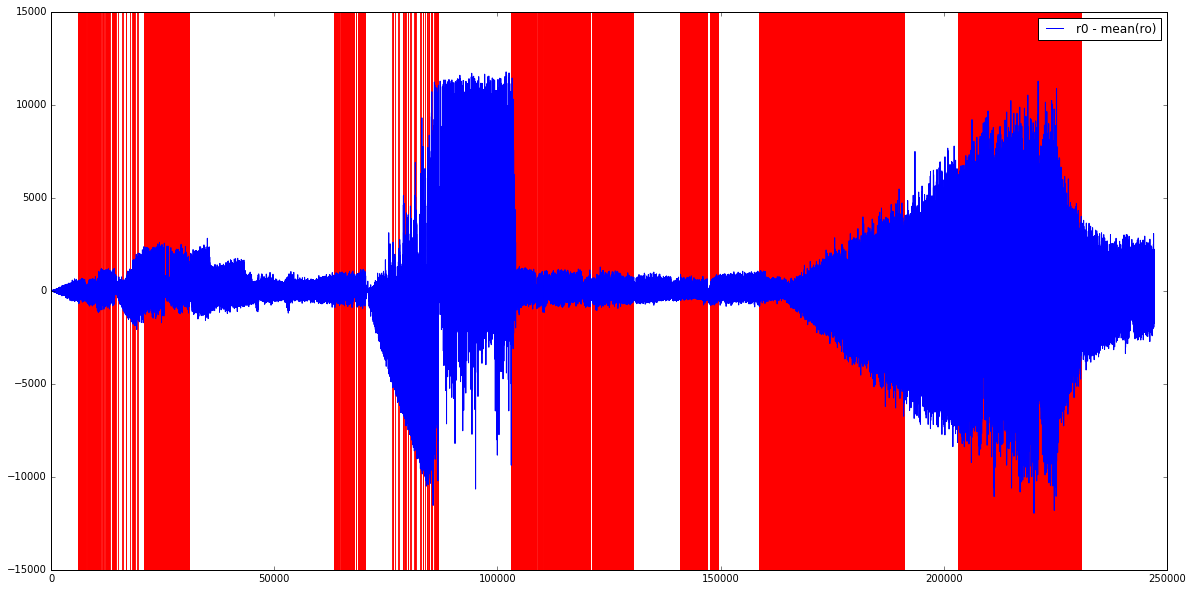

In [109]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
earthquake_big_time = np.where(y == 1)[0]
[ax.axvline(i, c='r', alpha=0.9) for i in earthquake_big_time];
ax.plot(X['r_mean'], label='r0 - mean(ro)');
plt.legend();

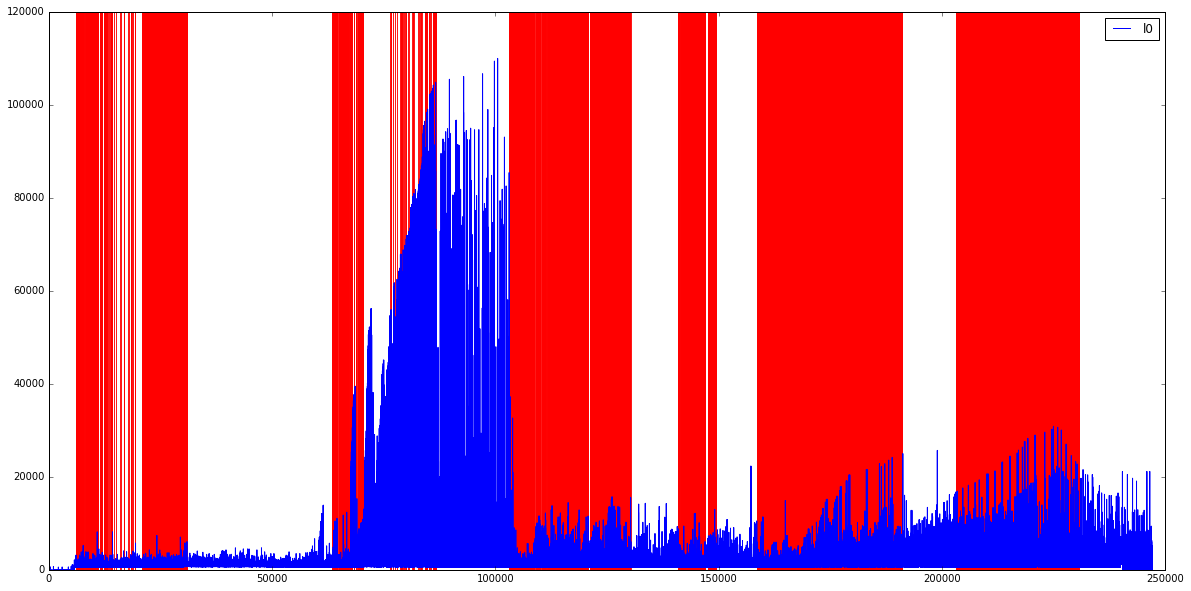

In [115]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
earthquake_big_time = np.where(y == 1)[0]
[ax.axvline(i, c='r', alpha=0.9) for i in earthquake_big_time];
ax.plot(X['l0'], label='l0');
plt.legend();

In [394]:
make_anomaly_start = pd.DataFrame()
make_anomaly_start['r'] = X['r0']
make_anomaly_start['r_detrend'] = X['r_mean']
make_anomaly_start['l'] = X['l0']
make_anomaly_start['l_detrend'] = X['l_mean']
make_anomaly_start['t'] = X['t0']
make_anomaly_start['t_detrend'] = X['t_mean']
make_anomaly_start['rtl_detrend'] = X['RTL_mean']

In [400]:
make_anomaly_start.head(n=5)

,r,r_detrend,l,l_detrend,t,t_detrend,rtl_detrend
0,0.913419,-1.220135,0.016145,-0.052482,1.992477,-3.300407,-1.454628
1,1.565481,-0.498165,0.072603,0.003925,2.985940,-2.206142,-1.113371
2,0.755759,-1.297161,0.019977,-0.045671,3.986534,-1.504250,-1.394243
3,2.629488,0.408094,0.241800,0.154570,4.985915,-0.504305,1.410904
4,1.685724,-0.394433,0.043732,-0.038202,5.983442,0.494216,-1.182677


In [398]:
make_anomaly_train, y_train, make_anomaly_test, y_test = make_anomaly_on_q_level(make_anomaly_start.copy(), y, 0.99, 0.01)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [399]:
recall_score(y_test, make_anomaly_test['l'])

0.069729084783829304

In [328]:
def make_anomaly_on_q_level(make_anomaly, y, quantile_up, quantile_down):
    train_size = 50000
    make_anomaly_train, y_train = make_anomaly.loc[:train_size,:], y[:train_size]
    make_anomaly_test, y_test =  make_anomaly.loc[train_size:,:], y[train_size:]

    threshods = []
    for i in make_anomaly.columns:
        find_quantile = np.sort(make_anomaly_train[i].values)
        threshods.append((find_quantile[train_size * quantile_up], find_quantile[train_size * quantile_down]))

    for col, thr in zip(make_anomaly.columns, threshods):
        make_anomaly[col] = (np.array(make_anomaly[col]) > 1. * thr[0]) | (np.array(make_anomaly[col]) < -1. * thr[1])

    make_anomaly_train, y_train = make_anomaly.loc[:train_size-1,:], y[:train_size]
    make_anomaly_test, y_test =  make_anomaly.loc[train_size:,:], y[train_size:]
    
    return make_anomaly_train, y_train, make_anomaly_test, y_test

In [440]:
def make_metrics(make_anomaly, y, quantile_up, quantile_down, iter_n='0'):
    make_anomaly_train, y_train, make_anomaly_test, y_test = make_anomaly_on_q_level(make_anomaly, y,\
                                                                                     quantile_up, quantile_down)

    precision = []
    recall = []
    specifity = []
    f_one = []

    for i in make_anomaly.columns:
        conf_matrix = confusion_matrix(y_test, make_anomaly_test[i])
        specifity.append(conf_matrix[0,0] * 1.0 / (conf_matrix[0,0] + conf_matrix[0,1]))
        precision.append(precision_score(y_test, make_anomaly_test[i]))
        recall.append(recall_score(y_test, make_anomaly_test[i]))
        f_one.append(f1_score(y_test, make_anomaly_test[i]))
    
    result = pd.DataFrame({'specifity': specifity, 'precision': precision, 'recall': recall, 'f_one': f_one})
    result.index = [i + '_' + iter_n for i in ['r', 'r_detrend', 'l', 'l_detrend', 't', 't_detrend', 'rtl_detrend']]
    #print(conf_matrix)
    return result

In [441]:
q_u = [0.75, 0.85, 0.95, 0.99]
q_d = [0.25, 0.15, 0.05, 0.01]

In [443]:
make_anomaly_start = pd.DataFrame()
make_anomaly_start['r'] = X['r0']
make_anomaly_start['r_detrend'] = X['r_mean']
make_anomaly_start['l'] = X['l0']
make_anomaly_start['l_detrend'] = X['l_mean']
make_anomaly_start['t'] = X['t0']
make_anomaly_start['t_detrend'] = X['t_mean']
make_anomaly_start['rtl_detrend'] = X['RTL_mean']

result = []
for u, d, n in zip(q_u, q_d, range(len(q_u))):
    result.append(make_metrics(make_anomaly_start.copy(), y, u, d, str(n)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [434]:
temp = pd.concat([result[0], result[1], result[2], result[3]], axis=1)

In [469]:
tabel_all = (result[0].append(result[1]).append(result[2]).append(result[3])).sort_index()

In [477]:
(tabel_all.ix[['l_0', 'l_detrend_0', 'r_0', 'r_detrend_0', 'rtl_detrend_2', 't_2', 't_detrend_2'],:]).round(2)

,f_one,precision,recall,specifity
l_0,0.27,0.17,0.63,0.48
l_detrend_0,0.25,0.14,1.00,0.00
r_0,0.33,0.21,0.74,0.53
r_detrend_0,0.25,0.14,1.00,0.00
rtl_detrend_2,0.25,0.14,0.99,0.00
t_2,0.36,0.24,0.68,0.64
t_detrend_2,0.25,0.14,1.00,0.00


In [474]:
tabel_all

,f_one,precision,recall,specifity
l_0,0.267327,0.169658,0.630018,0.479121
l_1,0.242154,0.159700,0.500632,0.555013
l_2,0.168571,0.125346,0.257299,0.696706
l_3,0.065882,0.062437,0.069729,0.823123
l_detrend_0,0.252535,0.144515,1.000000,0.000000
l_detrend_1,0.252535,0.144515,1.000000,0.000000
l_detrend_2,0.248492,0.143009,0.947010,0.041331
l_detrend_3,0.247368,0.143060,0.913216,0.075927
r_0,0.327164,0.210127,0.738490,0.531057
r_1,0.323299,0.213544,0.665181,0.586165


In [478]:
import itertools

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [480]:
for i in make_anomaly.columns:
        print confusion_matrix(y_test, make_anomaly_test[i])

[[119419  49269]
 [ 16835  11661]]
[[  7450 161238]
 [  1591  26905]]
[[138851  29837]
 [ 26509   1987]]
[[ 12808 155880]
 [  2473  26023]]
[[114442  54246]
 [ 10903  17593]]
[[   695 167993]
 [   212  28284]]
[[  2106 166582]
 [   706  27790]]


In [486]:
np.sum(y_test == 0)

168688

In [482]:
119419+49269

168688

In [484]:
confusion_matrix(y_test, make_anomaly_test['r'])

array([[119419,  49269],
       [ 16835,  11661]])